In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import zarr

# Load data
# data = pd.read_csv('/path/to/your/data.csv')

In [2]:
# 1. Data Preparation
def read_cf_pair(dt, n):
    start, end = dt.index_range[n]
    timestamps = dt.timestamp[start:end]
    t = (timestamps-timestamps[0]) # read time and convert it to second

    veh_id = n
    # idx_range = dt.index_range[n]
    lead_centroid = dt.lead_centroid[start: end]
    follow_centroid = dt.follow_centroid[start: end]
    follow_velocity = dt.follow_velocity[start: end]
    lead_velocity = dt.lead_velocity[start: end]
    follow_acceleration = dt.follow_acceleration[start: end]
    lead_acceleration = dt.lead_acceleration[start: end]
    # size_lead = dt.lead_size[n] # this is for HV
    size_lead = 4.8
    size_follow = dt.follow_size[n]
    

    return veh_id, lead_centroid, follow_centroid, follow_velocity, follow_acceleration, lead_acceleration, lead_velocity, t, size_lead, size_follow

# For easier data manipulation, we convert the data into a pandas dataframe
# x_lead, x_follow, v_follow, a_follow, a_lead, v_lead, t, size_lead, size_follow = read_cf_pair(data, 120)

# whole dataset == 3054 vehicles
zarr_data = zarr.open('../data/valAV.zarr', mode='r')
data = pd.DataFrame(data=dict(zip(['veh_id','x_lead', 'x_follow', 'v_follow', 'a_follow', 'a_lead', 'v_lead', 't', 'size_lead', 'size_follow'], read_cf_pair(zarr_data, 1))))

for i in range (1, 20):
    data = data.append(pd.DataFrame(data=dict(zip(['veh_id','x_lead', 'x_follow', 'v_follow', 'a_follow', 'a_lead', 'v_lead', 't', 'size_lead', 'size_follow'], read_cf_pair(zarr_data, i)))))

# Calculate spacing and relative speed
data['spacing'] = data['x_lead'] - data['x_follow'] - data['size_lead']
data['relative_speed'] = data['v_lead'] - data['v_follow']

data.reset_index(inplace=True, drop=True)

/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_38623/1812054996.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(data=dict(zip(['veh_id','x_lead', 'x_follow', 'v_follow', 'a_follow', 'a_lead', 'v_lead', 't', 'size_lead', 'size_follow'], read_cf_pair(zarr_data, i)))))
/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_38623/1812054996.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(data=dict(zip(['veh_id','x_lead', 'x_follow', 'v_follow', 'a_follow', 'a_lead', 'v_lead', 't', 'size_lead', 'size_follow'], read_cf_pair(zarr_data, i)))))
/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_38623/1812054996.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [3]:
data

,veh_id,x_lead,x_follow,v_follow,a_follow,a_lead,v_lead,t,size_lead,size_follow,spacing,relative_speed
0,1,0.000000,-37.802712,12.061164,-0.290343,-0.562275,11.255709,0.000000,4.8,3.767852,33.002712,-0.805455
1,1,1.124804,-36.709237,12.048760,-0.304286,-0.563949,11.208600,0.099947,4.8,3.767852,33.034041,-0.840160
2,1,2.242104,-35.406041,12.037252,-0.326463,-0.566090,11.191046,0.199891,4.8,3.767852,32.848145,-0.846206
3,1,3.360586,-34.223488,11.982743,-0.353493,-0.568846,11.186157,0.299863,4.8,3.767852,32.784074,-0.796586
4,1,4.476336,-33.070545,11.930278,-0.379709,-0.572322,11.136099,0.399838,4.8,3.767852,32.746881,-0.794179
...,...,...,...,...,...,...,...,...,...,...,...,...
4621,19,285.651977,265.305324,14.153424,-0.318339,-0.033901,13.561639,21.500071,4.8,3.613545,15.546653,-0.591784
4622,19,287.007957,266.708477,14.111323,-0.294181,-0.053117,13.564076,21.600012,4.8,3.613545,15.499480,-0.547247
4623,19,288.362964,268.101629,14.092003,-0.272060,-0.076354,13.533821,21.699962,4.8,3.613545,15.461335,-0.558182
4624,19,289.713263,269.459774,14.072073,-0.247578,-0.102638,13.487391,21.799953,4.8,3.613545,15.453488,-0.584683


In [4]:
# Preprocess data
features = ['v_follow', 'spacing', 'relative_speed']
target = 'a_follow'

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

target_scaler = MinMaxScaler()
data[[target]] = target_scaler.fit_transform(data[[target]])

In [5]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length + 1):
        seq = data.iloc[i:i+seq_length][features].values
        label = data.iloc[i+seq_length-1][target]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [6]:
# train_size = int(len(data) * 0.7) + seq_length - 1
# train_data, test_data = data.iloc[:train_size], data.iloc[train_size-seq_length+1:]

seq_length = 50

# Assume that 'pair_id' is the column that identifies each pair of trajectories
train_data = data[data['veh_id'] < 19]
test_data = data[data['veh_id'] == 19]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
# Create DataLoader objects
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, drop_last=False)

In [8]:
print(test_data.tensors)

(tensor([[[0.8583, 0.3652, 0.6104],
         [0.8550, 0.3681, 0.6131],
         [0.8544, 0.3703, 0.6109],
         ...,
         [0.9353, 0.3676, 0.4784],
         [0.9335, 0.3672, 0.4800],
         [0.9320, 0.3666, 0.4829]],

        [[0.8550, 0.3681, 0.6131],
         [0.8544, 0.3703, 0.6109],
         [0.8513, 0.3733, 0.6141],
         ...,
         [0.9335, 0.3672, 0.4800],
         [0.9320, 0.3666, 0.4829],
         [0.9290, 0.3657, 0.4878]],

        [[0.8544, 0.3703, 0.6109],
         [0.8513, 0.3733, 0.6141],
         [0.8493, 0.3764, 0.6176],
         ...,
         [0.9320, 0.3666, 0.4829],
         [0.9290, 0.3657, 0.4878],
         [0.9270, 0.3654, 0.4955]],

        ...,

        [[0.8155, 0.3587, 0.6808],
         [0.8134, 0.3635, 0.6880],
         [0.8123, 0.3684, 0.6953],
         ...,
         [0.9679, 0.3530, 0.4532],
         [0.9650, 0.3518, 0.4581],
         [0.9637, 0.3509, 0.4569]],

        [[0.8134, 0.3635, 0.6880],
         [0.8123, 0.3684, 0.6953],
         [0

In [9]:
# Build LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, input_seq):
        h_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size)
        c_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size)
        out, _ = self.lstm(input_seq, (h_0, c_0))
        out = self.linear(out[:, -1, :])
        return out

In [10]:
input_size = 3
hidden_layer_size = 100
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_layer_size, num_layers, output_size)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Train the model
epochs = 150
for i in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred.view(-1), labels)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch {i:3} loss: {single_loss.item():10.10f}')

epoch   1 loss: 0.00423900
epoch  26 loss: 0.00261436
epoch  51 loss: 0.00023087
epoch  76 loss: 0.00002476
epoch 101 loss: 0.00002271
epoch 126 loss: 0.00005572
epoch 149 loss: 0.0000068369


In [12]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test.view(-1, seq_length, input_size))

In [13]:
# Denormalize the data
y_test_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
y_pred_denorm = target_scaler.inverse_transform(y_pred.view(-1, 1)).reshape(-1)

In [14]:
print(y_test_denorm)


[-0.33101563 -0.31968322 -0.30846871 -0.29785426 -0.28602272 -0.27824996
 -0.28321143 -0.30220042 -0.33844811 -0.38486903 -0.42732199 -0.46191914
 -0.48070561 -0.48057915 -0.46373969 -0.42002492 -0.33963479 -0.23559383
 -0.12557789 -0.01796307  0.07024154  0.14245585  0.21188241  0.26561238
  0.29490171  0.31025921  0.32074668  0.3355282   0.37141625  0.42109127
  0.46976067  0.526201    0.59374201  0.66366533  0.7301752   0.78306997
  0.80672356  0.80495552  0.78601022  0.74101086  0.66540548  0.56856592
  0.46020355  0.35021524  0.25475935  0.17113605  0.09082356  0.02511507
 -0.01855496 -0.04810011 -0.07103101 -0.09452695 -0.13213976 -0.17667394
 -0.21420793 -0.2514432  -0.29037086 -0.32739953 -0.36369894 -0.39368254
 -0.40912438 -0.41539005 -0.41965449 -0.42021388 -0.41879139 -0.4147621
 -0.40397    -0.38897135 -0.372109   -0.35211348 -0.3290531  -0.30296088
 -0.27296398 -0.24170106 -0.21289453 -0.18788385 -0.16910751 -0.15807262
 -0.15523186 -0.16354296 -0.18592973 -0.21808063 -0.

In [15]:
print(y_pred_denorm)


[-0.38435122 -0.38183009 -0.38600663 -0.38860606 -0.37283866 -0.32962657
 -0.26021197 -0.20823966 -0.19523105 -0.20724273 -0.24356477 -0.2771771
 -0.30536608 -0.34848922 -0.38752465 -0.40358931 -0.39687795 -0.33745723
 -0.25825023 -0.20182411 -0.14436725 -0.01070521  0.1041643   0.19400194
  0.24523788  0.21947622  0.20818052  0.15721144  0.12866559  0.11858553
  0.11925295  0.1518252   0.22588176  0.28976246  0.40763749  0.47465609
  0.49300686  0.54265925  0.55113444  0.52933153  0.44803567  0.39256305
  0.29724415  0.19138435  0.12694545  0.03437138 -0.10354943 -0.21106227
 -0.28388452 -0.35635437 -0.41698111 -0.46732223 -0.46343795 -0.41607642
 -0.37274787 -0.38147703 -0.40073209 -0.38593767 -0.38711935 -0.39394388
 -0.36968971 -0.31449054 -0.29832759 -0.31070772 -0.31924674 -0.338481
 -0.35774106 -0.37117129 -0.37061571 -0.35972781 -0.34006324 -0.32209671
 -0.30550122 -0.28029921 -0.26236163 -0.24428009 -0.18933331 -0.16775332
 -0.17845212 -0.18655992 -0.21432965 -0.2340837  -0.29

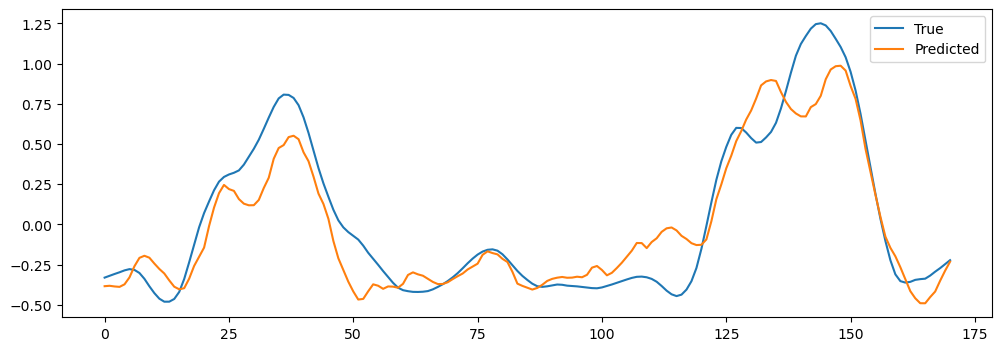

In [16]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 4))
plt.plot(y_test_denorm, label='True')
plt.plot(y_pred_denorm, label='Predicted')
plt.legend()
plt.show()

In [18]:
np.save('y_test_denorm_20.npy', y_test_denorm)
np.save('y_pred_denorm_20.npy', y_pred_denorm)

In [ ]:
y_test_speed = 